# Style Transfer
Style transfer is a novel application of convolutional neural networks that has nothing to do with predicting or classifying anything. The idea is to take two template images, one for "style" and one for "content", and combine the stylistic elements of one image with the content of the other image to create a new and novel piece of art. 

The mechanism by which this is achieved is still through gradient descent, with a few new twists. 

__1.__ We are minimizing a new loss function, one that describes the difference of the network's output and the desired "style" and "content" of the two template images. 

__2.__ Instead of updating kernel weights during gradient descent, we are updating the pixels of what is initially an image of white noise (random pixel values). 

The mystery in all of this is how we define the differences between style and content, and then how we mathematically extract them from an image. 

## Defining Content and Style
If you've studied how convolutional neural networks learn, you probably know that each convolutional layer is made up of a stack of filters (AKA kernels) that are applied to incoming data to extract features. In the first few layers, especially before applying any pooling, a lot of information is retained. However, as we proceed deeper into the network, the output of given filters tends lose specificity while retaining specific structural patterns within the image. This is on purpose, and is what allows our network to generalize to unseen data. 



In [1]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, transforms, models

import requests
from io import BytesIO
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [19]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [23]:
def load_image(path, max_size=400, shape=None):
    if 'http' in path:
        response = requests.get(path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')
        
    
    if shape is not None:
        size = shape
    elif max(image.size) > max_size:
        size = max_size   
    else:
        size = max(image.size)
    
    in_transform = transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                             (0.229, 0.224, 0.225))])
    
    return in_transform(image).unsqueeze(0)

In [21]:
def get_features(model, image):

    layers = {
        '0' : 'conv1_1',
        '5' : 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    
    features = {}
    
    x = image
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

In [131]:
# load in content and style image, and create target image
content = load_image('data/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('data/magritte.jpg', shape=content.shape[-2:]).to(device)
# Target image on which gradient descent will be performed:
target = content.clone().requires_grad_(True).to(device)

In [132]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

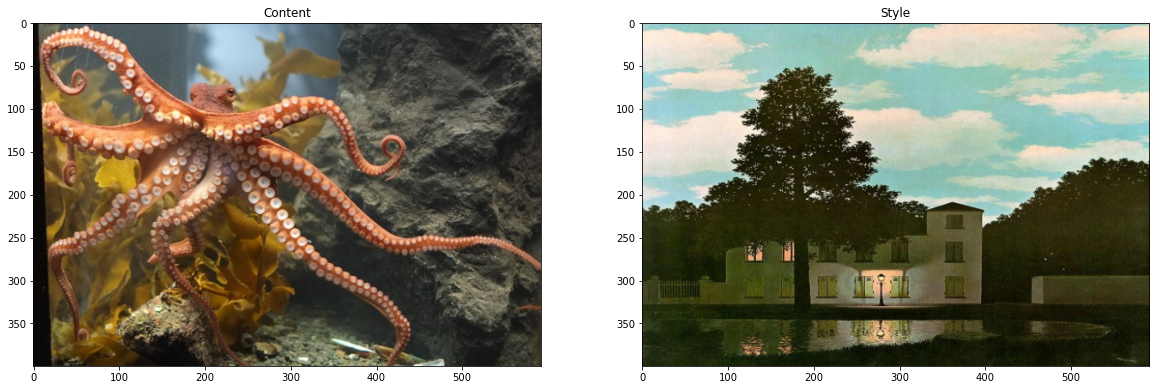

In [133]:
# display the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax1.set_title('Content')
ax2.set_title('Style');

In [136]:
# weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


def gramian(tensor):
    """
    Compute the gramian matrix of a single feature map
    """
    t = tensor.view(512, -1)
    return t @ t.T

def content_loss(c_features, t_features):
    """
    Compute mean squared error of all feature maps. 
    """
    loss = (t_features['conv4_2'] - c_features['conv4_2']) ** 2
    return torch.mean(loss)

def style_loss(s_grams, t_features, weights):
    """
    Compute style loss, i.e. the weighted sum of MSE of all layers. 
    """
    # for each style feature, get target and style gramians, compare
    loss = 0
    for layer in weights:
        _, d, h, w = s_features[layer].shape
        t_gram = gramian(t_features[layer])    
        
        layer_loss = torch.mean((t_gram - s_grams[layer]) ** 2) / (d * h * w)
        loss += layer_loss * weights[layer]
    
    return loss     

1
Total loss:  7706710.5


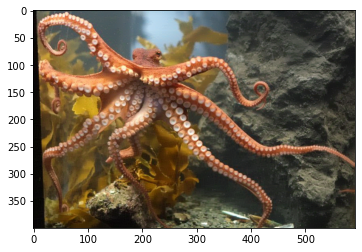

2
Total loss:  7346779.5


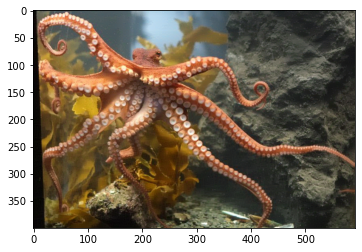

3
Total loss:  7016536.5


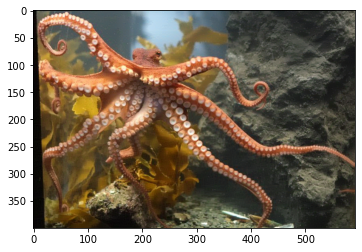

4
Total loss:  6717730.0


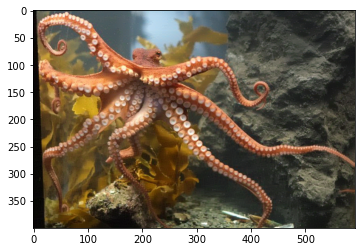

5
Total loss:  6447409.5


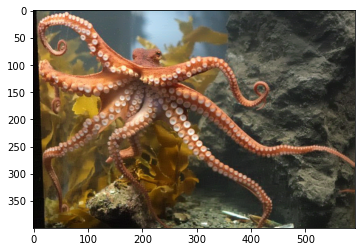

In [142]:
show  = 1
steps = 5
c_weight = 1
s_weight = 1e6

s_features = get_features(vgg, style)
c_features  = get_features(vgg, content)
s_grams = {layer: gramian(features) for layer, features in s_features.items()}

opt = optim.Adam([target], lr=0.003)

for step in range(1, steps + 1):
    opt.zero_grad()
    
    t_features = get_features(vgg, target)
    c_loss = content_loss(c_features, t_features)
    s_loss = style_loss(s_grams, t_features, style_weights)
    
    total_loss = c_weight * c_loss + s_weight * s_loss
    total_loss.backward()
    opt.step()
    
    print(step)
    
    if step % show == 0:
            print('Total loss: ', total_loss.item())
            plt.imshow(im_convert(target))
            plt.show()